In [2]:
import numpy as np

from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib import pyplot as plt

import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
from pycuda.gpuarray import GPUArray

# Linear Wave Equation in 2D
The acoustic wave equation in 2D can be written
$$
\begin{align}
\frac{\partial^2 u}{\partial t^2} &= c^2 \nabla^2 u\\
&= c^2 \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$
where $u$ is the string/surface position, and c is a material specific constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t^2} (u_{i, j}^{n+1} - 2u_{i, j}^{n} + u_{i, j}^{n-1}) 
= c \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right]
$$
and gathering $u^n+1$ on the left hand side and $u^n$ on the right, we write
$$
u^{n+1}_{i,j} = 2u_{i,j}^n - u_{i, j}^{n-1}
+ \frac{c\Delta t^2}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{c\Delta t^2}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{c\Delta t}{\Delta x^2}, \qquad
\frac{1}{2} \gt \frac{c\Delta t}{\Delta y^2}
$$
or 
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2c}, \frac{\Delta y^2}{2c}\right)
$$

In [3]:
class LinearWaveGPU(object):
    def __init__(self):
        pass
        
    def initialize(self, u1, u0, c, dx, dy, dt, block_width=16, block_height=4):        
        self.c = np.float32(c)
        self.dx = np.float32(dx)
        self.dy = np.float32(dy)
        self.dt = np.float32(dt)
        self.nx = np.int32(u0.shape[1]-2)
        self.ny = np.int32(u0.shape[0]-2)
        
        self.block_size = (block_width, block_height, 1)
        self.grid_size = (int(np.ceil(self.nx / block_width)), int(np.ceil(self.ny / block_height)), 1)
        self.stream = cuda.Stream()
        
        self.u2_gpu = GPUArray(u1.shape, u1.dtype)
        self.u1_gpu = GPUArray(u1.shape, u1.dtype)
        self.u0_gpu = GPUArray(u0.shape, u0.dtype)
        
        self.u0_gpu.set_async(u0, stream=self.stream)
        self.u1_gpu.set_async(u1, stream=self.stream)
        
        
        cuda_kernel = \
        """
        #define BLOCK_WIDTH {:d}
        #define BLOCK_HEIGHT {:d}
        """.format(block_width, block_height) \
        + \
        """
        __global__ void linearWaveEqn(float* u2, const float* u1, const float* u0, float c, float dx, float dy, float dt, int nx, int ny) {
            //Plus one to skip the "ghost cells"
            int i = blockIdx.x*blockDim.x + threadIdx.x + 1;
            int j = blockIdx.y*blockDim.y + threadIdx.y + 1;
            int tx = threadIdx.x + 1;
            int ty = threadIdx.y + 1;

            //First read into shared memory, including the local ghost cells / apron
            __shared__ float u1_shared[BLOCK_HEIGHT+2][BLOCK_WIDTH+2];
            for (int l=threadIdx.y; l<BLOCK_HEIGHT+2; l += blockDim.y) {
                int t = min(blockIdx.y*blockDim.y + l, ny);
                for (int k=threadIdx.x; k<BLOCK_WIDTH+2; k += blockDim.x) {
                    int s = min(blockIdx.x*blockDim.x + k, nx);
                    u1_shared[l][k] = u1[t*(nx+2) + s];
                }
            }
            __syncthreads();

            //Then fix the boundary conditions
            if (i == 1) {
                u1_shared[ty][tx-1] = u1_shared[ty][tx];
            }
            else if (i == nx) {
                u1_shared[ty][tx+1] = u1_shared[ty][tx];
            }
            else if (j == 1) {
                u1_shared[ty-1][tx] = u1_shared[ty][tx];
            }
            else if (j == ny) {
                u1_shared[ty+1][tx] = u1_shared[ty][tx];
            }
            __syncthreads();

            if (i >= 1 && i <= nx && j >= 1 && j <= ny) {
                u2[j*(nx+2) + i] = 2.0f*u1_shared[ty][tx] - u0[j*(nx+2)+i]
                    + c*dt/(dx*dx) * (u1_shared[ty][tx-1] - 2.0f*u1_shared[ty][tx] + u1_shared[ty][tx+1])
                    + c*dt/(dy*dy) * (u1_shared[ty-1][tx] - 2.0f*u1_shared[ty][tx] + u1_shared[ty+1][tx]);
            }
        }
        """
        self.module = SourceModule(cuda_kernel, \
                                            options=['--use_fast_math'])
        self.linear_wave_kernel = self.module.get_function("linearWaveEqn");
        self.linear_wave_kernel.prepare("PPPffffii")
        
    def step(self):
        self.linear_wave_kernel.prepared_async_call(self.grid_size, self.block_size, self.stream, \
                                                    self.u2_gpu.gpudata, self.u1_gpu.gpudata, self.u0_gpu.gpudata, \
                                                    self.c, self.dx, self.dy, self.dt, self.nx, self.ny)
        self.u0_gpu, self.u1_gpu, self.u2_gpu = self.u1_gpu, self.u2_gpu, self.u0_gpu    
    
    def download(self):
        u1 = np.empty(self.u1_gpu.shape, self.u1_gpu.dtype)
        self.u1_gpu.get(u1)
        return u1
        
# Set simulation parameters
c = 1.0
nx, ny = 100, 50
dx = 1.0
dy = 2.0
dt = 0.2 * min(dx / (2.0*c), dy / (2.0*c))

# Initial conditions
u0 = np.zeros((ny, nx), dtype=np.float32)
for j in range(ny):
    for i in range(nx):
        x = (i - nx/2.0) * dx
        y = (j - ny/2.0) * dy
        if (np.sqrt(x**2 + y**2) < 10*min(dx, dy)):
            u0[j, i] = 10.0
u1 = np.copy(u0)

simulator = LinearWaveGPU()
simulator.initialize(u1, u0, c, dx, dy, dt)

In [4]:
fig = plt.figure()

use_3d = True

# Initialize plot
if (use_3d):
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.linspace(0, nx*dx, nx), np.linspace(0, ny*dy, ny)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, u1, cmap=cm.coolwarm, linewidth=0, antialiased=True, vmin=-5, vmax=5)
    ax.set_zlim(-5, 10)
else:
    domain_extent = [0, nx*dx, 0, ny*dy]
    im = plt.imshow(u1, origin='lower', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
    plt.colorbar()

def animate(i):
    print(".", end='', flush=True)
    if (i > 0):
        for k in range(10):
            simulator.step()
    
    u2 = simulator.download()
    
    if (use_3d):
        ax.clear()
        surf = ax.plot_surface(X, Y, u2, cmap=cm.coolwarm, linewidth=0, antialiased=True, vmin=-5, vmax=5)
        ax.set_zlim(-5, 10)
    else:
        im.set_data(u2)

plt.rcParams["animation.html"] = "html5"
anim = FuncAnimation(fig, animate, range(30), interval=100)
plt.close()
anim

...............................

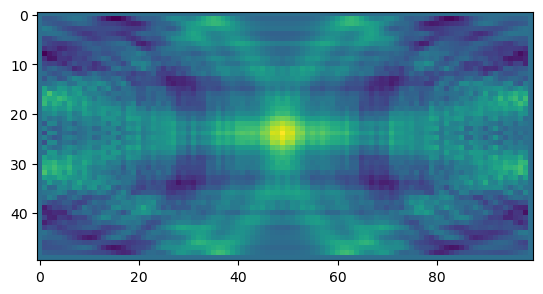

In [5]:
u2 = simulator.download()
plt.imshow(u2)